# Deep Neural Networks Problem Sheet

### Please complete this prior to the problem class on Friday 4th March 2022

In this assignment you will explore some of the model architectures talked about in the second half of lectures.

# A: Residual Networks

In these questions we will work with residual networks (ResNets). In order to save time, we won't be training these models ourselves. Pytorch provides pre-*trained* weights for a range of commonly used models in the `torchvision` package, including ResNets of various depth. Most of the pretrained ResNets available are slightly improved versions of those proposed in 'Deep Residual Learning for Image Recognition' by [He et al (2015)](https://arxiv.org/pdf/1512.03385.pdf).

Note: you can request colab to run a GPU by going to Runtime -> Change runtime type. However, since we are only going to work with single images, it is unlikely this will buy you significant speedup.


## Setting up: Blas the border collie

To start, we will look at whether ResNets of different length can correctly classify my friend's dog Blas as a Border Collie.

In [2]:
!wget https://caballerojose.com/images/blas.jpg -P blas_the_dog/test

--2022-03-03 22:25:43--  https://caballerojose.com/images/blas.jpg
Resolving caballerojose.com (caballerojose.com)... 185.199.109.153, 185.199.110.153, 185.199.111.153, ...
Connecting to caballerojose.com (caballerojose.com)|185.199.109.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 221678 (216K) [image/jpeg]
Saving to: ‘blas_the_dog/test/blas.jpg’

blas.jpg            100%[===================>] 216.48K  --.-KB/s    in 0.06s   

2022-03-03 22:25:44 (3.41 MB/s) - ‘blas_the_dog/test/blas.jpg’ saved [221678/221678]



### Loading an image

We will use the Python Imaging Library (PIL) to load the image. Colab then displays the image in-line if it is the output of the last line in the cell. Hello Blas!

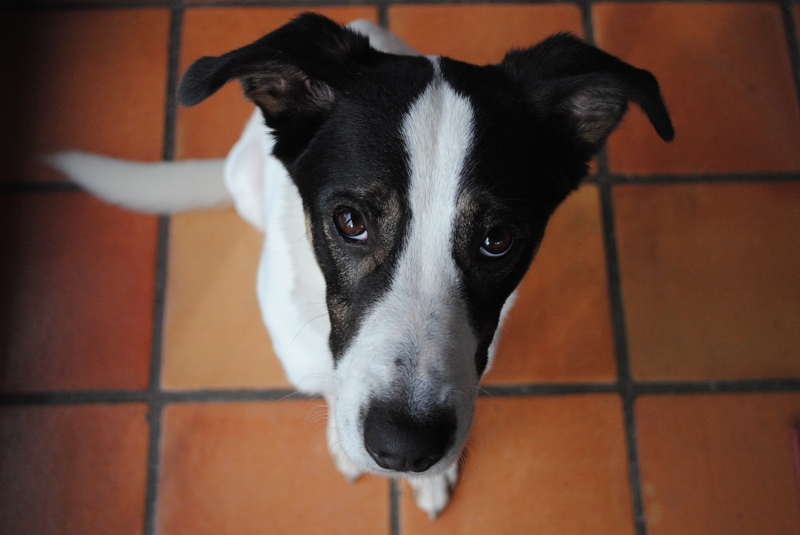

In [98]:
from PIL import Image
import matplotlib.pyplot as plt
img = Image.open('blas_the_dog/test/blas.jpg')
img.resize((800,535))

### Transformations

ConvNets expect input images to be of a certain size, otherwise the dimensions of the tensors within the network don't work out. We have to resize this image so it is of size $224\times 224$ as the network expects. Secondly, when training neural networks, we often normalise the inputs (substract the mean and divide by the standard deviation). As this model was trained on ImageNet, we have to use the mean and standard deviation from this dataset. Thankfully, we don't have to compute this, as it's included in the [pytorch documentation](https://pytorch.org/vision/0.8/models.html) (as well as elsewhere on the internet).

We will use `transforms` from the `torchvision` module to apply these transformations to the image. We also convert from `PIL.Image` to `torch.Tensor` in the process:


In [3]:
from torchvision import transforms

transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(
                                    mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225]
                                )])

img_t = transform(img)

We can display the transformed image by converting it back to `PIL.Image`. We can see that the image was downsized, cropped to it's centre square region, and the colours are messed up due to normalization.

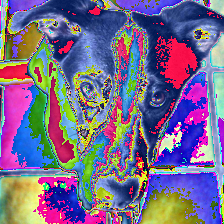

In [4]:
transforms.ToPILImage()(img_t)

### Loading  the model

Now we are going to load the pre-trained 18-layer ResNet model from the `torchvision` library.

In [5]:
from torchvision import models

resnet18 = models.resnet18(pretrained=True)

Let's see how the model classifies Blas, the border collie. For this, we have to turn the image tensor into a minibatch of 1 example, which practically means adding an extra dimension to the tensor. This can be done using the `unsqueeze` function.

In [6]:
x = img_t.unsqueeze(0)
y = resnet18(x)
y.size()

torch.Size([1, 1000])

The model's output is a vector of 1000 logits, one for each class in the ImageNet dataset. To interpret this, we have to know what the ImageNet classes are. Also, the logits themselves are less human-readable, so we are going to turn them into probabilities using a `softmax` function. This helper function below will do this for us.

In [10]:
import requests
import json
from torch.nn.functional import softmax

imagenet_labels_url = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
response = requests.get(imagenet_labels_url)
imagenet_class_names = json.loads(response.text)

def top_5_classes(y, class_names = None):
  if class_names==None:
    imagenet_labels_url = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
    response = requests.get(imagenet_labels_url)
    class_names = json.loads(response.text)
  p = softmax(y[0,:], dim=0)
  values, indices = p.topk(5)
  return [(class_names[index], value) for index, value in zip(indices.detach().numpy(), values.detach().numpy())]

In [9]:
top_5_classes(y)

[('bucket', 0.0078050834),
 ('plunger', 0.007231565),
 ('hook', 0.0070612985),
 ('waste container', 0.005460199),
 ('water bottle', 0.005441311)]

Oops, the model doesn't seem to recognise Blas. It thinks Blas is a bucket, plunger or hook. This is because in order to use the pretrained models in pytorch, we have to set them to evaluation mode. When training deep neural networks, sometimes the networks work differently at training and test time. For example, when using a technique called dropout, random units in the network may be dropped at training time, but at test time, all units are used and their output is scaled. Similarly, when using batch normalisation, the network works differently in training time and at test time. To set models to evaluation mode we can use the `eval` function.

In [10]:
resnet18.eval()
y = resnet18(x)
top_5_classes(y)

[('Staffordshire Bull Terrier', 0.18592504),
 ('Cardigan Welsh Corgi', 0.13814497),
 ('American Staffordshire Terrier', 0.13022634),
 ('Basenji', 0.08973376),
 ('Whippet', 0.08941802)]

OK, getting there. At least the model now recognises Blas as a dog, but misses the specific breed. The correct class would be a Border Collie.

## Question A.1: Trying different pretrained networks

Now try different models from `torchvision` and see which ones can classify Blas correctly. In particular, check out deeper versions of ResNets. Use the [documentation](https://pytorch.org/vision/0.8/models.html) to find out what other networks are available. Use the code blocks below, and the text field to summarise what you found. (For full marks, try multiple ResNets, and at least two different non-ResNets).

*10 marks*

### Answer A.1

Please use this cell to summarise which networks you tried.

In [11]:
resnext50_32x4d = models.resnext50_32x4d(pretrained=True).eval()
y = resnext50_32x4d(x)
top_5_classes(y)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /Users/ira/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100.0%


[('Border Collie', 0.35082653),
 ('Cardigan Welsh Corgi', 0.31425193),
 ('Australian Kelpie', 0.17195036),
 ('Basenji', 0.07098298),
 ('collie', 0.051720522)]

## Inspecting and modifying networks

For the next question, you will need to modify the pre-trained networks, and you will need to look inside them. Below, we share a few things that will help you learn how models work. First, let's look at what the `resnet18` architecture looks like and how that architecture is represented in pytorch. You can print the model to see a text description of it:

In [12]:
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Here, modules are listed from top to bottom in order of how they are executed.In a pytorch ResNet, residual blocks are organised into `layers`, each of which contain sequences of residual blocks. You will notice that:
* the number of channels keeps doubling at each layer, in this case from 128 -> 256 -> 512.
* at the same time, the figure size is halved with each layer. The image size is halved by `MaxPool2d` layers as well as strided convolutions where the stride is `2`.
* a `resnet18` is built out of `BasicBlock` building blocks, which are the simple residual block proposed by [He et al, (2015)](https://arxiv.org/abs/1512.03385) which I showed in the lecture. Deeper ResNets, such as `resnet50` use a more complicated `Bottleneck` component instead.
* in pytorch, the linear and nonlinear parts of a layer are separate, i.e. the convolution and subsequent ReLU activation are handled as separate layers.

To access the second convolution layer from the second residual block at the third layer, you can write the following:

In [13]:
resnet18.layer3[1].conv2

Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

And you can access parameters of layers like so.

In [14]:
resnet18.conv1.weight.size()

torch.Size([64, 3, 7, 7])

We can visualise the convolution kernels on the first layer using the code below. In addition to showing how to access weights, you may find some of this code useful as an example of using the `matplotlib.pylab` package for plotting.

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


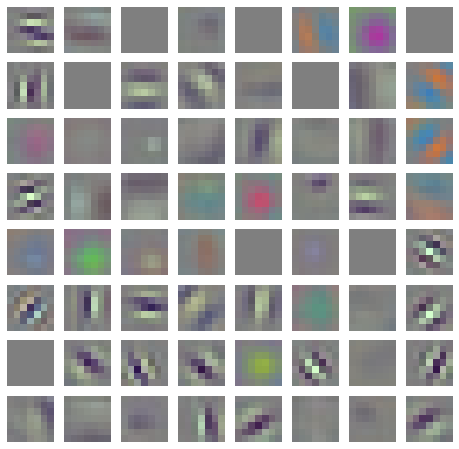

In [15]:
import numpy as np
from matplotlib import pylab as plt

f = plt.figure(figsize = (8,8))

weights = resnet18.conv1

print(weights)

weights = resnet18.conv1.weight.detach().numpy()
#normalising weights so a value of 0 becomes gray, and colours stay within [0,1]
weights = weights/(np.abs(weights).max())/2+0.5

#there are 64 convolution kernels, which we will arrange along an 8x8 grid
for i, w in enumerate(weights):
  plt.subplot(8, 8, i+1)
  # we move the colour channel axis to the end, this is where imshow expects it
  plt.imshow(np.moveaxis(w, 0, -1));
  plt.axis('off')

In pytorch, you can inspect what each layer of the network does by using forward hooks. A forward hook is a python function that gets called whenever the layer is evaluated (i.e. data is passed through the layer). The forward hook function receives both the input and the output of the module. In pytorch, you can add a forward hook using the register_forward_hook function. 

For example, in the code below, I attach a hook to a layer, which simply prints something out. Instead of attaching the hook to the resnet18, I first create a `deepcopy` of the model, so the hook gets attached to the copy, but not to the `resnet18` model which I may use later.

In [59]:
import copy

def useless_hook(module, input, output):
  print('The hook was called.')

model = copy.deepcopy(resnet18)
model.layer3[1].conv2.register_forward_hook(useless_hook)
y = model(x)

The hook was called.


## Question A.2: Inspecting layers in neural networks

This question has a subtasks:
1. print the number of parameters in each of the operations/layers of the `ResNet18`, and count how many there are in total.
1. print the *shape of the output tensor* of the second convolution operation (`conv2`) within every single residual block in a `ResNet18`. *Tip:* you can use a forward hook.
1. Extract the activation (output) of a layer of your choice within the ResNet18, and visualise the activations using `matplotlib.pylab.imshow`. *Tip:* you can use a forward for this here, too.
1. Visualise the convolution weights (also called kernels) in the first convolution layer of a pretrained AlexNet and a VGG19 network. Compare it to what we obtained the ResNet above. Document the similarities and differences do you notice.


*Tips:*
* you can use `copy.deepcopy` to create copies of models.
* You can use `tensor.size()` to get the sape.
* you have to use `tensor.detach().numpy()` to detach a pytorch tensor from the computational graph and convert it to a numpy array.
* for plotting, you can use the `matplotlib.pylab` module. The function `imshow` can be usedd to plot activation maps as images, `axis('off')` is handy for removing axis labels. `subplot` allows you to create grids of multiple images in one figure, finally `figure(figsize=(x, y))` lets you change the overall size of the figure.
* on a pytorch module you can call `named_children` and `name_parameters` to iterate over layers and parameters, respectively.

*15 marks*

### Answer A.2

please provide your answers in code cells below (you may use multiple code cells).

In [17]:
total_params = 0
layers = np.zeros(4)
others = 0
for name, parameter in model.named_parameters():
    if not parameter.requires_grad: continue
    params = parameter.numel()
    for i in range(1, 4+1):
        if 'layer{}'.format(i) in name: layers[i-1]+=params
    if 'layer' not in name: others+=params
    total_params+=params
for i in range(1, 4+1):
    print("Trainable Params in layer {}: {}".format(i, layers[i-1]))
print("Trainable Params in first and last fully connected layers: {}".format(others))
print(f"Total Trainable Params: {total_params}")
print(f"Verify by summing all above: {others + sum(layers)}")
    

Trainable Params in layer 1: 147968.0
Trainable Params in layer 2: 525568.0
Trainable Params in layer 3: 2099712.0
Trainable Params in layer 4: 8393728.0
Trainable Params in first and last fully connected layers: 522536
Total Trainable Params: 11689512
Verify by summing all above: 11689512.0


In [18]:
def useful_hook(module, input, output):
    name, parameter in module.named_parameters()
    print(len(parameter))

model = copy.deepcopy(resnet18)
model.layer1[1].conv2.register_forward_hook(useful_hook)
model.layer2[1].conv2.register_forward_hook(useful_hook)
model.layer3[1].conv2.register_forward_hook(useful_hook)
model.layer4[1].conv2.register_forward_hook(useful_hook)
y = model(x)

1000
1000
1000
1000


In [19]:
def return_activation(module, input, output):
    return output.detach().numpy()

model = copy.deepcopy(resnet18)
model.layer1[1].conv2.register_forward_hook(return_activation)
#y = model(x)
#plt.imshow(y)

In [20]:
#AlexNet
alexnet = models.alexnet(pretrained=True)
print(alexnet)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /Users/ira/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100.0%


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

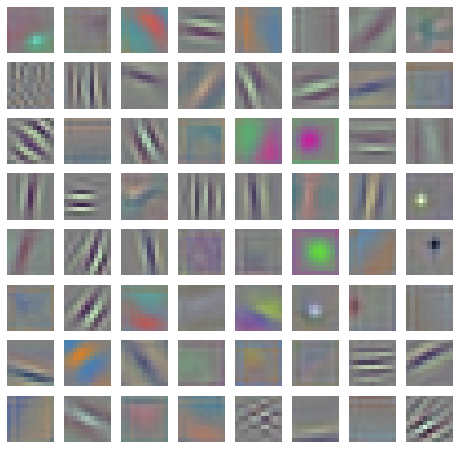

In [21]:
f = plt.figure(figsize = (8,8))

weights = alexnet.features[0].weight.detach().numpy()

#normalising weights so a value of 0 becomes gray, and colours stay within [0,1]
weights = weights/(np.abs(weights).max())/2+0.5

#there are 64 convolution kernels, which we will arrange along an 8x8 grid
for i, w in enumerate(weights):
  plt.subplot(8, 8, i+1)
  # we move the colour channel axis to the end, this is where imshow expects it
  plt.imshow(np.moveaxis(w, 0, -1));
  plt.axis('off')

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


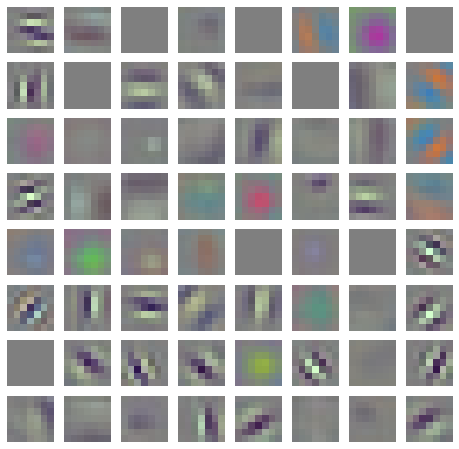

In [22]:
#resnet for comparison

f = plt.figure(figsize = (8,8))

weights = resnet18.conv1

print(weights)

weights = resnet18.conv1.weight.detach().numpy()
#normalising weights so a value of 0 becomes gray, and colours stay within [0,1]
weights = weights/(np.abs(weights).max())/2+0.5

#there are 64 convolution kernels, which we will arrange along an 8x8 grid
for i, w in enumerate(weights):
  plt.subplot(8, 8, i+1)
  # we move the colour channel axis to the end, this is where imshow expects it
  plt.imshow(np.moveaxis(w, 0, -1));
  plt.axis('off')

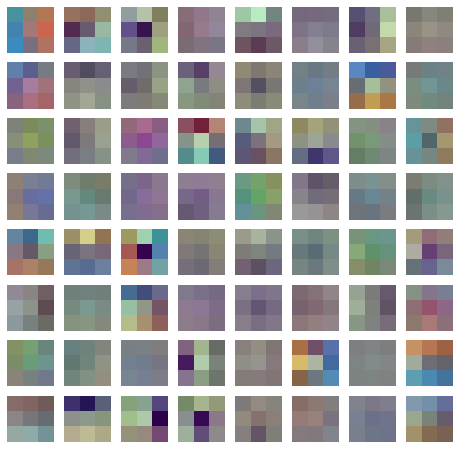

In [28]:
#AlexNet
f = plt.figure(figsize = (8,8))

weights = models.vgg16(pretrained=True).features[0].weight.detach().numpy()

#normalising weights so a value of 0 becomes gray, and colours stay within [0,1]
weights = weights/(np.abs(weights).max())/2+0.5

#there are 64 convolution kernels, which we will arrange along an 8x8 grid
for i, w in enumerate(weights):
  plt.subplot(8, 8, i+1)
  # we move the colour channel axis to the end, this is where imshow expects it
  plt.imshow(np.moveaxis(w, 0, -1));
  plt.axis('off')

## Editing models

Models can be edited rather flexibly in pytorch. Underlying a pytorch `Module` are python `OrderedDict` objects. These are ordered lists of key-value pairs. Each submodule and each parameter has a name, which is the key. Members of the dictionay can be accessed as attributes of the `Module`. Adding a new parameter or layer to a module will add a new key-value pair to this dictionary.

Let's try adding a new operation to our resnet18, which converts the logits to probabilities. We will do this by replacing the final operation by a `Sequential` module, which chains multiple operations together.

In [29]:
from torch.nn import Softmax, Sequential

model = copy.deepcopy(resnet18)
model.fc = Sequential(
    model.fc,
    Softmax(dim=1)
    )

In [9]:
#let's see what the model looks like now
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Let's check the model still works and that it outputs a vector of probabilities which therefore sums to one.

In [30]:
y = model(x)
print(y.sum())

tensor(1.0000, grad_fn=<SumBackward0>)


We can also replace existing layers with other layers. Here, for example, I replace the first convolution layer with a randomly initialized one of the same dimensions. We can check what effect this has on the classification of Blas:

In [34]:
from torch.nn import Conv2d

model = copy.deepcopy(resnet18)
model.conv1 = Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
y = model(x)
top_5_classes(y)

[('window screen', 0.20643507),
 ('window shade', 0.13802373),
 ('shower curtain', 0.10565343),
 ('strainer', 0.09805894),
 ('lampshade', 0.08285884)]

Or, if we replace the convolutional layer by the convolutions from the VGG19 network, followed by a MaxPooling, to account for the difference in stride, the network becomes pretty certain that Blas is, in fact, spider web, or possibly a type of spider.

In [35]:
from torch.nn import MaxPool2d

vgg19 = models.vgg19(pretrained=True)

model = copy.deepcopy(resnet18)
model.conv1 = Sequential(
      vgg19.features[0],
      MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False))
y=model(x)
top_5_classes(y)

[('spider web', 0.9051275),
 ('barn spider', 0.038777407),
 ('European garden spider', 0.013474083),
 ('window screen', 0.011838877),
 ('wolf spider', 0.004304728)]

## Question A.3: Dropping layers in ResNet15

This question is composed of several tasks:
1. Delete the second `BasicBlock` from `layer4` of the ResNet18, and see how the network's predictions change. 
1. Delete the first `BasicBlock` from `layer4` of the ResNet18, and see how the network's predictions change. (Note, this is a bit morer involved than the previous one).
1. Delete the first `BasicBlock` from `layer2` of the ResNet18, and see how the network's predictions change.

Tips:
* There are several ways for removing a ResNet block:
  * The easiest perhaps is to replace the entire block with a `torch.nn.Identity`. This works for blocks where the output and input featuremap size are the same. However, some of the residual blocks also reduce the size of the image (strided convolutions, or Max Pooling), so replacing by the Identity won't work. This is why the second task is a bit harder than the first. To find out what you have to do in the second task, look closely at the difference between the two `BasicBlock` instances within `layer4`. To understand how this block works, you can also look at the [source code](https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py#L67).
  * Since the activations are all ReLU, you can also ignore the effect of layers by setting appropriate weights and biases to zero. This is because $\operatorname{ReLU}(0z).= 0$. However, if you are trying to use this method, be aware of batch normalization layers - you also want to remove the effect of those.
  * You will notice that the layers of ResNets are of `torch.nn.Sequential` type. You can drop an element from this by creating a new `Sequential` instead with one operation removed.
* You can solve this task using a few lines of code only.

*15 marks*

### Answers A.3

Please provide your answer in the code blocks below.

In [78]:
#1. dropping layer4 second block
import torch
model_a3_1 = copy.deepcopy(resnet18)
model_a3_1.layer4[1] = torch.nn.Identity()
y=model_a3_1(x)
top_5_classes(y)

[('hook', 0.0014269283),
 ('ladle', 0.0013750901),
 ('tennis ball', 0.0013631867),
 ('mop', 0.0013223541),
 ('vacuum cleaner', 0.0013204612)]

In [85]:
#1. dropping layer4 second block
import torch
model_a3_1 = copy.deepcopy(resnet18)

def deactivate_batchnorm(m):
    if isinstance(m, torch.nn.BatchNorm2d):
        m.reset_parameters()
        m.eval()
        with torch.no_grad():
            m.weight.fill_(0)
            m.bias.zero_()

model_a3_1.layer4[1].apply(deactivate_batchnorm)           
y=model_a3_1(x)
top_5_classes(y)

[('hook', 0.0014269283),
 ('ladle', 0.0013750901),
 ('tennis ball', 0.0013631867),
 ('mop', 0.0013223541),
 ('vacuum cleaner', 0.0013204612)]

In [86]:
#2. dropping layer4 first block
model_a3_2 = copy.deepcopy(resnet18)
model_a3_2.layer4[0].apply(deactivate_batchnorm)
y=model_a3_2(x)
top_5_classes(y)

[('bucket', 0.0046225437),
 ('paper towel', 0.0038443296),
 ('waste container', 0.0034820307),
 ('weasel', 0.003230916),
 ('cauldron', 0.0029107276)]

In [87]:
#2. dropping layer2 first block
model_a3_3 = copy.deepcopy(resnet18)
model_a3_3.layer2[0].apply(deactivate_batchnorm)
y=model_a3_3(x)
top_5_classes(y)

[('bucket', 0.008926814),
 ('hook', 0.006604846),
 ('plunger', 0.0055755717),
 ('water bottle', 0.005373524),
 ('pole', 0.0052755307)]

## A convenience function: flattening ResNets

Residual blocks in pytorch ResNets are organised into 4 layers. I found this rather cumbersome for the next exercise we are going to do. In order to make ResNets easier to work with I created the convenience function below which can *flatten* the layer hierarchy of pytorch resnet models, merging the 4 layers into one, called `residual_blocks`. After flattening, instead of accessing `model.layer1[0]` you can do `model.residual_blocks[0]`.

In [60]:
from torch import nn
from collections import OrderedDict

def flatten_resnet(resnet_model):
  """
  Takes a pytorch resnet model and returns a copy of the same model in a 
  flattened format, where the residulal blocks are not divided into four layers
  but are instead all in a residual blocks component.
  """
  model = copy.deepcopy(resnet_model)
  residual_blocks = nn.Sequential(*model.layer1,
                *model.layer2,
                *model.layer3,
                *model.layer4)
  return nn.Sequential(OrderedDict([
     ('conv1', model.conv1),
     ('bn1', model.bn1),
     ('relu', model.relu),
     ('maxpool', model.maxpool),
     ('residual_blocks', residual_blocks),
     ('avgpool', model.avgpool),
     ('flatten', nn.Flatten()),
     ('fc', model.fc)
  ]))

## Question A.4: Dropping layers in ResNet50

Load a pretrained ResNet50, and evaluate the model's predictions on the photo of Blas. Does it get the breed correct? (Border Collie).

Look at the structure of the ResNet50. Identify the `Bottleneck` blocks which are used instead of `BasicBlock` building blocks in deeper ResNets. These are still arranged into 4 'layers', and there are 16 of them in total.

Drop each of the 16 `Bottleneck` blocks from the ResNet50 (one at a time, not all at once), and make predictions with each of the perturbed networks. Plot the predicted probability of the Border Collie class (ImageNet class number 232) as a function of the index of the layer dropped. Compare the probabilities you get with the probability for the unperturbed model. What do you see?

*20 marks*

In [108]:
model = models.resnext50_32x4d(pretrained=True)
print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [ ]:
y=model(x)
top_5_classes(y,)

In [47]:
def top_collie_(y, class_names = None):
  if class_names==None:
    imagenet_labels_url = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
    response = requests.get(imagenet_labels_url)
    class_names = json.loads(response.text)
  p = softmax(y[0,:], dim=0)
  values, indices = p.topk(1000)
  return [(class_names[index], value) for index, value in zip(indices.detach().numpy(), values.detach().numpy()) if class_names[index]=='Border Collie'][0]

Border Collie 0.0011251763
Border Collie 0.0011189396
Border Collie 0.0012090654
Border Collie 0.0011425636
Border Collie 0.0011471824
Border Collie 0.0013329936
Border Collie 0.0012071764
Border Collie 0.0012088905
Border Collie 0.0012363843
Border Collie 0.0011926147
Border Collie 0.0011744505
Border Collie 0.0010474218
Border Collie 0.0011927148
Border Collie 0.0012035214
Border Collie 0.0010910794
Border Collie 0.0010151295


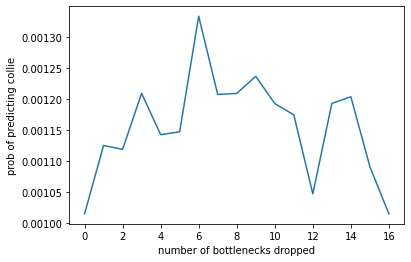

In [106]:
model = copy.deepcopy(models.resnext50_32x4d(pretrained=True))
label, prob = top_collie_(y)
collie_probs = [prob]
for i in range(3):
    model.layer1[i].apply(deactivate_batchnorm)
    y=model(x)
    label, prob = top_collie_(y)
    print(label, prob)
    collie_probs.append(prob)
for i in range(4):
    model.layer2[i].apply(deactivate_batchnorm)
    y=model(x)
    label, prob = top_collie_(y)
    print(label, prob)
    collie_probs.append(prob)
for i in range(6):
    model.layer3[i].apply(deactivate_batchnorm)
    y=model(x)
    label, prob = top_collie_(y)
    print(label, prob)
    collie_probs.append(prob)
for i in range(3):
    model.layer4[i].apply(deactivate_batchnorm)
    y=model(x)
    label, prob = top_collie_(y)
    print(label, prob)
    collie_probs.append(prob)

plt.plot(range(0, 17), collie_probs)
plt.xlabel("number of bottlenecks dropped")
plt.ylabel("prob of predicting collie")
plt.show()


## Question A.5: Permuting and Repeating Layers

Now, let's see what happens if we permute or repeat layers in the ResNet.

1. Permute layers: Swap `resnet50.layer2[1]` and `resnet50.layer2[3]` in the network (so that instead of the second `Bottleneck` unit in `layer2` you use the fourth and vice versa). Make predictions with the modified network. How did perturbing the model this way modify the predictions?
1. Repeat a residual block in the ResNet. Apply the second `Bottleneck` block of `layer2` of the ResNet twice instead of just once, making the model deeper. Make predictions with the modified model. What do you find?
1. Now repeat the layer 2, 3, 4, 5 times. Do the predictions keep improving?

*15 marks*

### Answers A.5

Please add text in this box, and use as many code cells below as you'd like.

In [107]:
model = copy.deepcopy(models.resnext50_32x4d(pretrained=True))
save_layer = model.layer2[1]
model.layer2[1] = model.layer2[3]
model.layer2[3] = save_layer
print(model)
print(top_collie_(y))

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

# B: Recurrent Networks

In this part of the assignment, we will train simple recurrent networks to detect messages hidden in binary strings.

## Backgroud

### Creating the dataset

Below, I included a function which creates a pytorch `Dataset` we will use in the questions below. 


In [ ]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

def get_binary_dataset(num_datapoints, signature_length=20, random_length=20):
  '''
  Creates a labelled dataset of `num_datapoints` binary sequences. Each sequence
  is of total length `signature_length + random_length`. Positive examples have
  a signature string of length `signature_length` embedded starting at a random
  location within the string. The signature is a binary string of alternating 1s
  and 0s. Negative examples are random bitstrings. They may contain the
  signature by chance, although the probability of this diminishes as the
  `signature_legth` increases.

  The returned dataset contains positive examples first, followed by negatives.
  When using minibatch-SGD, the dataset has to be shuffled before broken into
  minibatches.
 
  Attributes
  ----------
  num_datapoints : int
    Number of datapoints to be generated. Half of the datapoints will be
    positive, the rest negative. If `num_datapoints==1` then the dataset will
    contain a single positive example.
  signature_length : int
    Length of the signature string
  random_length : int
    Number of random bits in the sequence in addition to the signature sequence.
  
  Returns
  -------
  torch.utils.data.TensorDataset
    Pytorch dataset containing the strings and their binary labels.
  '''
  num_positives = num_datapoints - num_datapoints // 2
  y = np.array([[1.0]]*num_positives + [[0.0]]*(num_datapoints - num_positives))
  X = np.random.randint(2, size=(num_datapoints, signature_length + random_length))
  signature = np.array((signature_length//2)*[1.0, 0.0])
  for i in range(num_positives):
    j = np.random.randint(random_length)
    X[i, j:(j+signature_length)] = signature
  X = torch.tensor(X, dtype=torch.float)[:, :, None]
  y = torch.tensor(y)
  return TensorDataset(X, y)

Below, I visualise a dataset of $100$ positive and $100$ negative sequences of lenth $40$ each. In the visualisation below, positive examples appear on top, negatives in the bottom half. Black pixels show $1$s, white pixels show $0$s. You can see the signature sequence `10101010101010101010` embedded in the positive examples at random locations.

*Notes:* You can see how I used `spy` to visualise a sparse matrix. This function can be used to show non-zero values in a matrix. The pytorch `TensorsDataset` object has a `tensors` attribute which contains the input and output tensors.

In [ ]:
from matplotlib import pylab as plt

ds = get_binary_dataset(200,
                        signature_length=20,
                        random_length=20)

plt.figure(figsize=(4, 16))
plt.spy(ds.tensors[0][:, :, 0].numpy())
plt.axis('off');

## Building a classifier

Now we're going to build a simple RNN-based classifier for classifying binary sequences. We are going to feed the sequence into an RNN, then extract the hidden state activations at the end of the sequence, finally apply a linear transformation to calculate the classifier output.

An RNN module returns two outputs, as explained in [the documentation](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html). We have to select a layer which selects the second output - which is the activation of the hidden state at the end of the sequence - rearranges and flattens it so it's ready to be fed into a linear layer.

*Note:* By applying a further `sigmoid`, this classifier output can be turned into a probability, like it was the case with `softmax` the ResNet example. We are not going to make the sigmoid part of the network, as training will be more numerically stable this way

In [ ]:
class extract_last_cell(nn.Module):
  '''Pytorch module which extracts and flattens the last hidden state of an RNN.
  '''
  def forward(self,x):
    _ , out = x
    return out.permute(1,0,2).flatten(start_dim=1)

def get_basic_RNN_classifier():
  return nn.Sequential(
    nn.RNN(input_size=1, hidden_size=20, num_layers=2, batch_first=True),
    extract_last_cell(),
    nn.Linear(in_features = 20*2, out_features=1)
  )

## Question B.1: Evaluating the loss

Evaluate the log-loss of a randomly initialized classifier on minibatches of training examples from the dataset we defined before.

*Tips:*
* you can use [`pytorch/utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) to sample minibatches of training data from the dataset
* or, you can also access the input and output tensors of a `TensorDataset` directly via the `tensors` attribute
* use [`torch.nn.BCEWithLogitsLoss`](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) or [`torch.nn.functional.binary_cross_entropy_with_logits`](https://pytorch.org/docs/stable/nn.functional.html)

*10 marks*

### Answer B.1

pleasse add answer in the code cell(s) below:

## Training the classifier

In the previous assignment we wrote a training loop to show how optimizers work in pytorch. For this assignment we are going to use ignite, a flexible module for reusable training loops in pytorch. We will install ignite, and then I provide a function you can use to train models on the sequence data.

In [ ]:
!pip install pytorch-ignite

In [ ]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss

def fit_model_basic(model, training_dataset, test_dataset):
  '''Fits a pytorch model to the training dataset using stochastic gradient
  descent and tracks progress on a test set.

  Arguments
  ---------
  model : pytorch.nn.Module
    pytorch model that can be evaluated on input tensor in the dataset, and
    returns a tensor that matches the shape of the output tensor.
  training_dataset : pytorch.util.data.Dataset
    used to train the model
  test_dataset : pytorch.util.data.Dataset
    used to evaluate the performance of the model at the end of each epoch

  Retuns
  ------
  pytorch.nn.Module
    the model after training
  '''

  train_loader = DataLoader(
      training_dataset,
      batch_size=100,
      shuffle=True
  )
  val_loader = DataLoader(
      test_dataset,
      batch_size=1000,
      shuffle=False,
  )

  optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
  criterion = nn.BCEWithLogitsLoss()

  trainer = create_supervised_trainer(model, optimizer, criterion)

  def thresholded_output_transform(output):
      y_pred, y = output
      y_pred = torch.heaviside(y_pred, values=torch.zeros(1))
      return y_pred, y

  val_metrics = {
      "accuracy": Accuracy(thresholded_output_transform),
      "bce": Loss(criterion)
  }
  evaluator = create_supervised_evaluator(model, metrics=val_metrics)

  @trainer.on(Events.ITERATION_COMPLETED(every=10))
  def log_training_loss(trainer):
      print(f"Epoch[{trainer.state.epoch}] Loss: {trainer.state.output:.2f}")

  @trainer.on(Events.EPOCH_COMPLETED)
  def log_training_results(trainer):
      evaluator.run(train_loader)
      metrics = evaluator.state.metrics
      print(f"Training Results - Epoch: {trainer.state.epoch}  Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['bce']:.2f}")

  @trainer.on(Events.EPOCH_COMPLETED)
  def log_validation_results(trainer):
      evaluator.run(val_loader)
      metrics = evaluator.state.metrics
      print(f"Validation Results - Epoch: {trainer.state.epoch}  Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['bce']:.2f}")

  trainer.run(train_loader, max_epochs=5)

  return model

The code above looks rather long and complicated, but that is because we ask ignite to log the progress of training in a very verbose way. Ignite uses python decorators (like the `@trainer.on(Events.EPOCH_COMPLETED)`) bits. You will find plenty of tutorials online if you google 'python decorators' if you want to learn more about them. In ignite, these decorators are used to register functions which are called when various events happen during training.

For example, `@trainer.on(Events.ITERATION_COMPLETED(every=10))` tells ignite to execute the function that's below it every 10th iteration is completed. You will find that this training loop is largely a copy of the example code provided in the [ignite master documentation](https://pytorch.org/ignite/quickstart.html#code).

One difference is that we use the `thresholded_output_transform` to tarnsform the network's output before [`Accuracy`](https://pytorch.org/ignite/metrics.html#ignite.metrics.Accuracy) metric can be evaluated. Accuracy compares binary predictions to binary labels. But our network outputs `logits` instead of binary predictors. To turn these into binary decisions, we have to determine whether the logits are above or below $0$, which is what the `heaviside` function does.

Ignite can do much more than what we ask it to do here. It's a flexible way of creating reproducible training loops for neural network training. It can handle distributed training over several machines, etc.

Let's now use our training loop to train a classifier on the binary dataset we created:

In [ ]:
ds_train = get_binary_dataset(5000, signature_length=10, random_length=10)
ds_test = get_binary_dataset(1000, signature_length=10, random_length=10)
rnn_classifier = get_basic_RNN_classifier()

fit_model_basic(rnn_classifier, ds_train, ds_test)

Oh no! The error doesn't seem like the loss is reduced. Let's try to fix this.



## Question B.2: Improving the SGD code

1. Create a new version of `fit_model_basic` function, call it `fit_model`. You will use this function in subsequent questions. Your function should take additional arguments allowing you to easily specify key hyperparameters of optimization: learning rate, batchsize, whatever else you find important.
1. Tune hyperparameters and change things until training works reliably. Consider [changing the optimizer](https://pytorch.org/docs/stable/optim.html) from vanilla SGD: you may try SGD with momentum, `Adam`, etc. You should be able to make this example work, i.e. reach $90\%+$ average accuarcy within a few seconds of training.

*Tips*:
 * You can try different learning rates, such as the [Karpathy constant](https://twitter.com/karpathy/status/801621764144971776). This is a joke, learning rates are usually problem-specific. Values between $0.1$ and $0.001$ are often tried.
 * If you want, you can run grid search: running training for different values of hyperparameters, and checkind which one produces the best results. If doing so, consider spacing parameter values logarithmically rather than linearly. I.e. it makes more sense to try learning rates $[0.001, 0.01, 0.1]$ than to try $[0.001, 0.002, 0.003, \ldots]$.

*15 marks*

### Answer B.2

Please modify the code in the cells below. You may use this text box to summarise the changes you made.

In [ ]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss

def fit_model(model, training_dataset, test_dataset):
  '''Fits a pytorch model to the training dataset using stochastic gradient
  descent and tracks progress on a test set.

  Arguments
  ---------
  model : pytorch.nn.Module
    pytorch model that can be evaluated on input tensor in the dataset, and
    returns a tensor that matches the shape of the output tensor.
  training_dataset : pytorch.util.data.Dataset
    used to train the model
  test_dataset : pytorch.util.data.Dataset
    used to evaluate the performance of the model at the end of each epoch

  Retuns
  ------
  pytorch.nn.Module
    the model after training
  '''

  train_loader = DataLoader(
      training_dataset,
      batch_size=100,
      shuffle=True
  )
  val_loader = DataLoader(
      test_dataset,
      batch_size=1000,
      shuffle=False,
  )

  optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
  criterion = nn.BCEWithLogitsLoss()

  trainer = create_supervised_trainer(model, optimizer, criterion)

  def thresholded_output_transform(output):
      y_pred, y = output
      y_pred = torch.heaviside(y_pred, values=torch.zeros(1))
      return y_pred, y

  val_metrics = {
      "accuracy": Accuracy(thresholded_output_transform),
      "bce": Loss(criterion)
  }
  evaluator = create_supervised_evaluator(model, metrics=val_metrics)

  @trainer.on(Events.ITERATION_COMPLETED(every=10))
  def log_training_loss(trainer):
      print(f"Epoch[{trainer.state.epoch}] Loss: {trainer.state.output:.2f}")

  @trainer.on(Events.EPOCH_COMPLETED)
  def log_training_results(trainer):
      evaluator.run(train_loader)
      metrics = evaluator.state.metrics
      print(f"Training Results - Epoch: {trainer.state.epoch}  Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['bce']:.2f}")

  @trainer.on(Events.EPOCH_COMPLETED)
  def log_validation_results(trainer):
      evaluator.run(val_loader)
      metrics = evaluator.state.metrics
      print(f"Validation Results - Epoch: {trainer.state.epoch}  Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['bce']:.2f}")

  trainer.run(train_loader, max_epochs=5)

  return model

In [ ]:
classifier = fit_model(get_basic_RNN_classifier(), ds_train, ds_test)

## Question B.3: Test on longer sequences

Now that you successfully trained an RNN, let's test how well it works when we use it on longer sequences than what it was trained on. Does it have the ability to remember? Remember we trained on datasets with `signature_length=10, random_length=10`, that is a total length of `20` binary symbols.

* create 5 test datasets with `signature_length` of $10$ but with different `random_length` parameters (e.g. $10$, $20$, $30$, $50$ and $100$)
* evaluate accuracy of your trained model on each of these test regimes - (without retraining!)
* plot the performance you achieve for different test sequence lengths
* describe what you find

*Tips:*
* look inside the `fit_model` function for tips on evaluating models using ignite components.

*20 marks*

### Answers B.3

Please complete the task in code cells below.

## Question B.4: Better models

Remember what we learned about vanilla RNN's ability to remember information over long time range. Pick a different RNN cell type that should have better ability to remember, and define a new network that uses this cell type. 
* Modify the function below to define an improved RNN classifier
* train an instance of this better RNN model on the same data we trained the previous classifier on
* repeat the analysis from Question 3 using your new model, and contrast your new architecture's performance with the vanilla RNN from before.

*15 marks*

### Answers B.4

Please edit the code below and add as many code cells as you would like to complete this task.

In [ ]:
def get_better_RNN_classifier():
  '''A better RNN architecture for solving the signature detection problem.
  '''
  return nn.Sequential(
    nn.RNN(input_size=1, hidden_size=20, num_layers=2, batch_first=True),
    extract_last_cell(),
    nn.Linear(in_features = 20*2, out_features=1)
  )

In [ ]:
classifier = fit_model(get_better_RNN_classifier(), ds_train, ds_test)

## Question B.5: Visualise memorization

Now we are going to visualize which parts of the input the trained architecture pays attention to when making its decision. This is going to be similar in spirit to [this distill post](https://distill.pub/2019/memorization-in-rnns/).
* take your pre-trained RNN classifier from the previous example
* generate a random positive input sequence (one that has a signature of length $10$ in it) and form an input tensor to the model.
* calculate the gradient of the model's output with respect to the input.

*Tips:*
* remember how we used `requires_grad` and `backward` and the `grad` attribute in the lecture to calculate the gradients of an RNN's hidden state with respect to the input sequence.
* remember the `TensorDataset` has a `tensors` argument which you can use to extract the input and output tensors from the dataset.

*15 marks*

### Answers B.5

Please add your solution to the code blocks below.